In [75]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =\
["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [76]:
df = pd.read_csv('/content/Fitbit_feature_merged_version_2023.06.26_ST-II&ST-V_Pre.csv')
target = "Activity"

In [77]:
classes = sorted(list(set(df[target])))

In [78]:
df.dropna(axis=0, how='any', inplace = True)
dataset = df.reset_index(drop=True)

In [79]:
df[target].value_counts()

Light       2048
Extreme      325
Moderate     143
Heavy        113
Name: Activity, dtype: int64

In [80]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df[target]=encoder.fit_transform(df[target])

In [81]:
df[target].value_counts() / df.shape[0]

2    0.779003
0    0.123621
3    0.054393
1    0.042982
Name: Activity, dtype: float64

In [82]:
X = df.iloc[:,11:]
y = df.loc[:,target]

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [84]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([2103, 73]) torch.Size([2103])
torch.Size([526, 73]) torch.Size([526])


In [85]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))
net = Net(X_train.shape[1])

In [86]:
criterion = nn.BCELoss()

In [87]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [89]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [90]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)
for epoch in range(1000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
      f'''epoch {epoch}
      Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
      Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
      ''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
      Train set - loss: 32.824, accuracy: 0.126
      Test  set - loss: 33.013, accuracy: 0.097
      
epoch 100
      Train set - loss: -74.893, accuracy: 0.045
      Test  set - loss: -82.51, accuracy: 0.034
      
epoch 200
      Train set - loss: -74.893, accuracy: 0.045
      Test  set - loss: -82.51, accuracy: 0.034
      
epoch 300
      Train set - loss: -74.893, accuracy: 0.045
      Test  set - loss: -82.51, accuracy: 0.034
      
epoch 400
      Train set - loss: -74.893, accuracy: 0.045
      Test  set - loss: -82.51, accuracy: 0.034
      
epoch 500
      Train set - loss: -74.893, accuracy: 0.045
      Test  set - loss: -82.51, accuracy: 0.034
      
epoch 600
      Train set - loss: -74.893, accuracy: 0.045
      Test  set - loss: -82.51, accuracy: 0.034
      
epoch 700
      Train set - loss: -74.893, accuracy: 0.045
      Test  set - loss: -82.51, accuracy: 0.034
      
epoch 800
      Train set - loss: -74.893, accuracy: 0.045
      Test  set - loss: -82.51, 

In [91]:
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

In [92]:
net = torch.load(MODEL_PATH)

In [93]:
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Extreme       0.00      0.00      0.00        53
       Heavy       0.03      1.00      0.07        18
       Light       0.00      0.00      0.00       423
    Moderate       0.00      0.00      0.00        32

    accuracy                           0.03       526
   macro avg       0.01      0.25      0.02       526
weighted avg       0.00      0.03      0.00       526



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


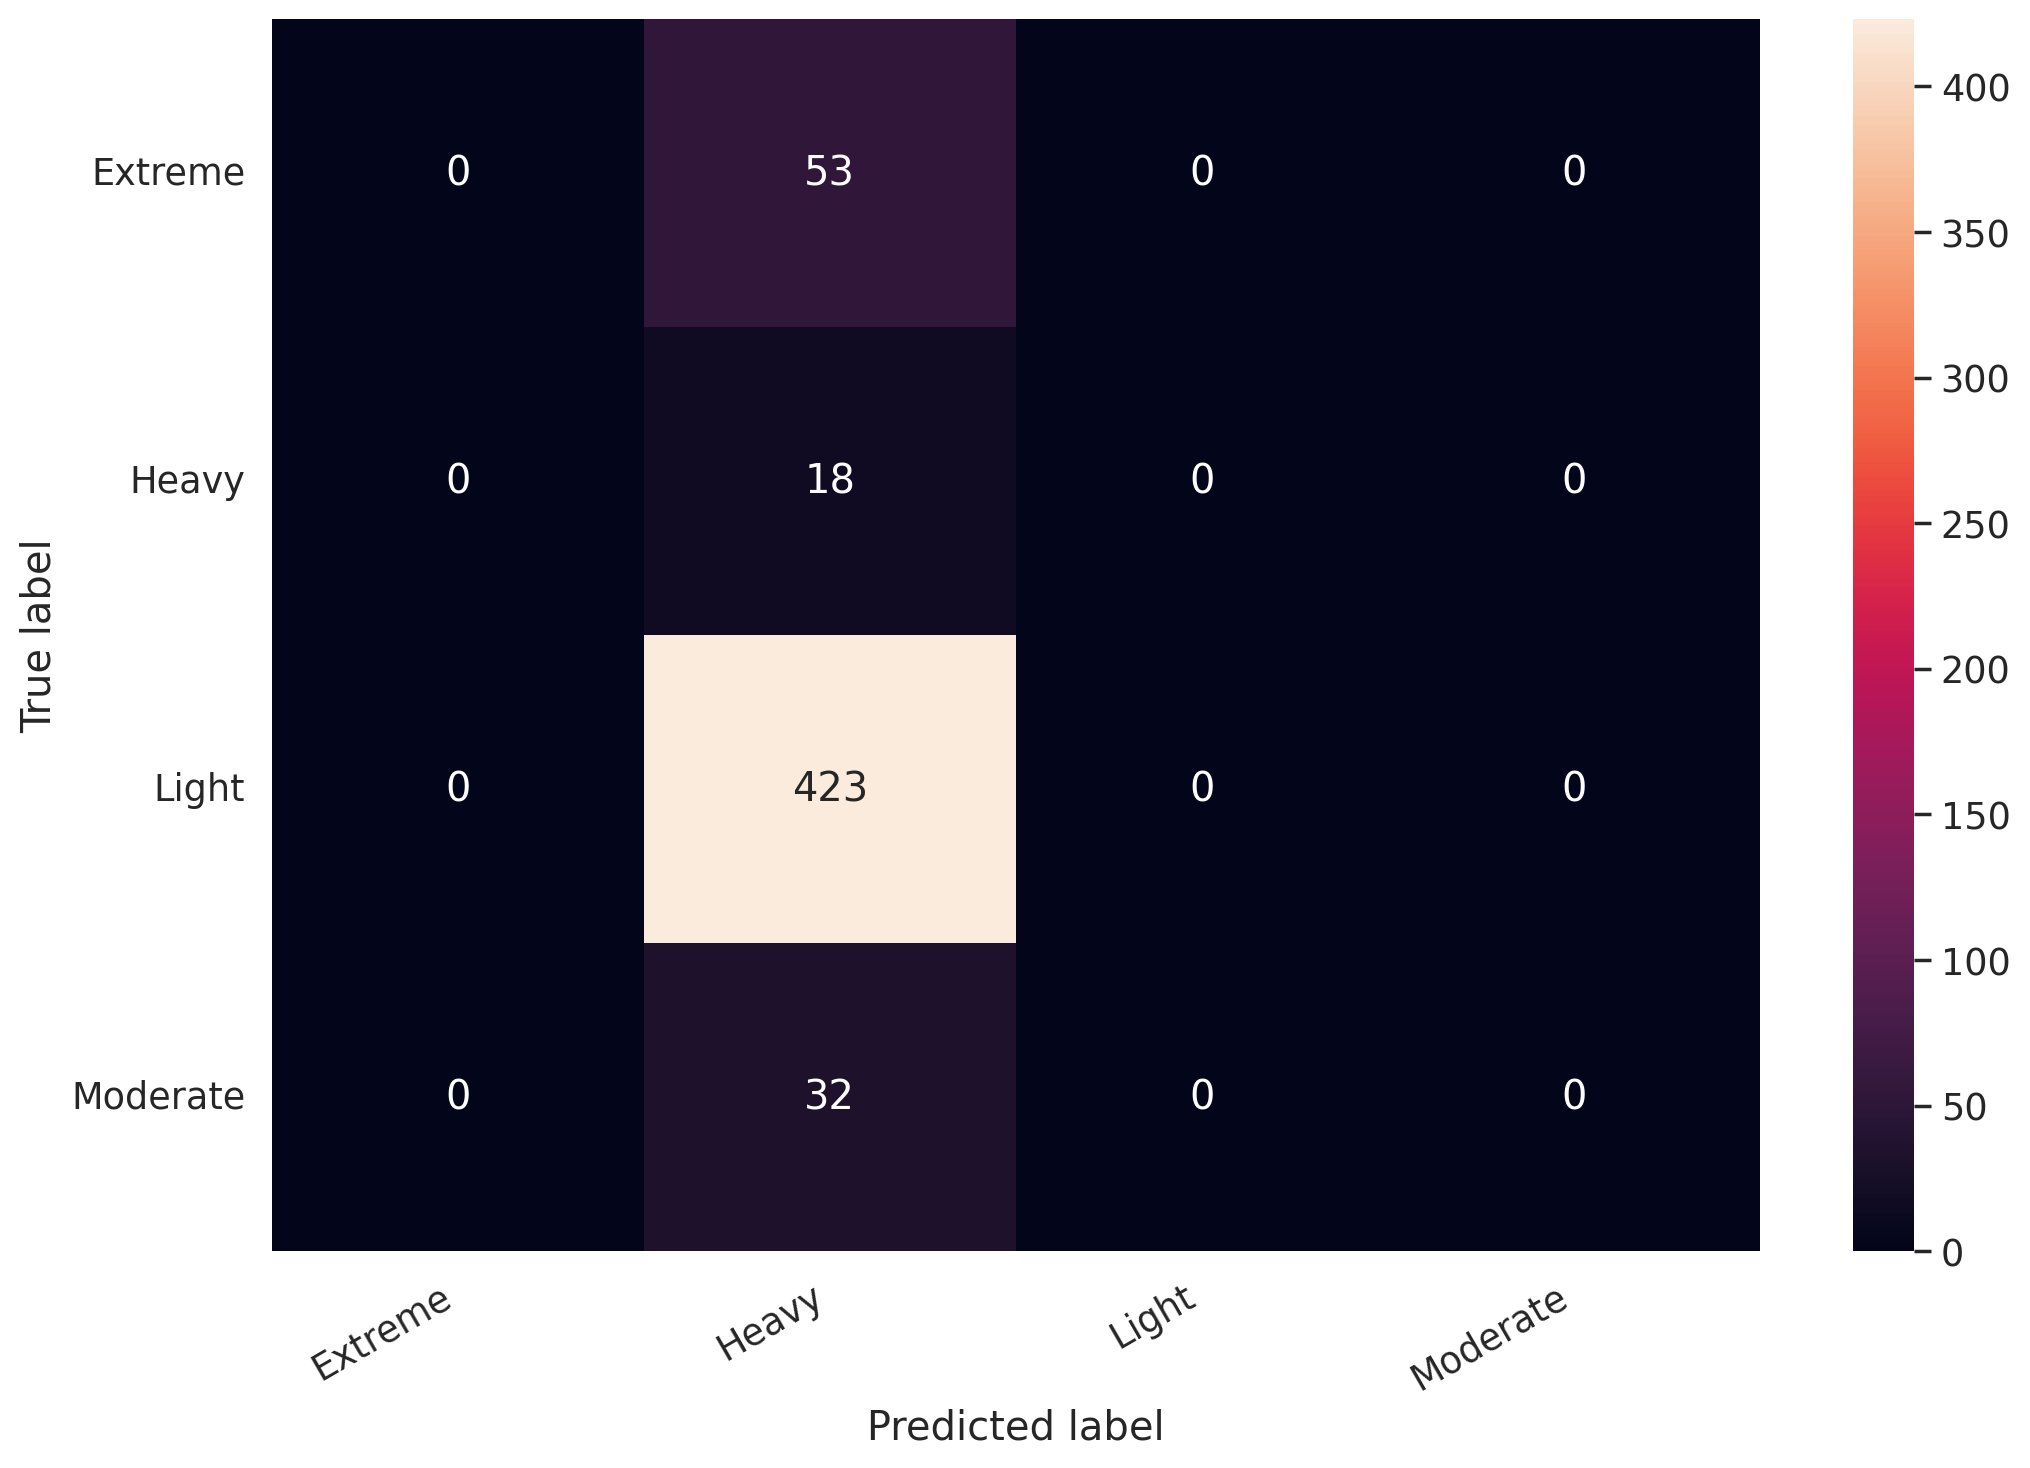

In [94]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');